# Part 1: Setup Project

## Objective

General setup:

- Install dependencies, import TensorFlow Layers
- Config GPU


## 1.1 Install and import dependencies, set up camera

In [1]:
import cv2 # OpenCV
import os  # For file operations
import random
import numpy as np
from matplotlib import pyplot as plt # For plotting graphs
from mtcnn.mtcnn import MTCNN
from numpy import savez_compressed
from PIL import Image

In [2]:
# Import TensorFlow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D,  Dense, MaxPool2D, Flatten, Input
import tensorflow as tf


The purpose of each Layer:

- Conv2D for Convolutional Neural Networks to extract features from the input images
- Dense for Fully Connected Neural Networks
- MaxPooling2D to pull our layers together and effectively reduce the number of parameters and computations in the network
- Flatten take output from previous layer and flatten it to a vector to be fed into the next layer

## 1.2 Setup GPU Limit for TensorFlow

In [3]:
# Avoid Memory Error when TensorFlow use two much VRAM
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus # Show all GPUs available in machine

[]

# Part 2: Load Preprocess Data and create training data 
## Objective

- Create positive and negative pairs with their labels from preprocessed data


## 2.1 Create pairs and labels for dataset

The Siamese network is integrated with preprocessing steps already, witohut sharing with the `DataPreprocessing.ipynb` notebook due to the approach of the model.

The process will be quite similar to the `DataPreprocessing.ipynb` notebook, but there will be some differences after the face detection step. 

In the `DataPreprocessing.ipynb` notebook, we used a pre train model to extract the the face embeddings. Just calling and it will do the job (aka, use model to give the prediction without training since it already pretrain model). However, in this Siamase Network, we even try to train the model how to extract these features.




Data organized into pairs:

     - Positive pairs: Two images of the same person
     - Negative pairs: Two images of different people
     
   - Training Process:
     - Network learns feature extraction from scratch
     - Pairs are fed through identical twin networks
     - Distance between feature vectors is computed
     - Loss function:
       * Minimizes distance for positive pairs
       * Maximizes distance for negative pairs
     - **Network iteratively improves feature extraction based on distance metrics**



In [5]:
# Now we create positive and negative pairs for the Siamese network


# Load face images from the .npz files
# Parameters:
# face_dir: directory containing the face images
def load_faces(face_dir):
    faces_dict = {}
    for subfolder in os.listdir(face_dir):  # Process each subfolder/person
        subfolder_path = os.path.join(face_dir, subfolder)
        if os.path.isdir(subfolder_path):
            data = np.load(os.path.join(subfolder_path, 'faces.npz'))
            faces = data['arr_0']
            faces_dict[subfolder] = faces
    return faces_dict  # Dictionary with key: person name, value: face images

# Create pairs of face images and corresponding labels
# Parameters: 
# faces_dict: dictionary containing face images of each person
# num_negative_samples: number of negative samples to create for each positive pair
# num_subfolders_to_sample: number of subfolders to sample for negative pairs
def create_pairs(faces_dict, num_negative_samples=5, num_subfolders_to_sample=3):
    pairs = []
    labels = []
    persons = list(faces_dict.keys())
    
    # Create positive pairs
    for person in persons:
        faces = faces_dict[person]
        for i in range(len(faces)):
            for j in range(i + 1, len(faces)):
                pairs.append([faces[i], faces[j]])
                labels.append(1)
    
    # Create negative pairs with random sampling
    for person in persons:
        faces = faces_dict[person]
        other_persons = [p for p in persons if p != person]
        sampled_persons = random.sample(other_persons, min(num_subfolders_to_sample, len(other_persons)))
        
        for face in faces:
            for sampled_person in sampled_persons:
                sampled_faces = faces_dict[sampled_person]
                sampled_negative_faces = random.sample(list(sampled_faces), min(num_negative_samples, len(sampled_faces)))
                
                for neg_face in sampled_negative_faces:
                    pairs.append([face, neg_face])
                    labels.append(0)
    
    return np.array(pairs), np.array(labels)

# Load face images
face_dir = './preprocessed_data(for_Siamese)/face_detect'
faces_dict = load_faces(face_dir)

# Create pairs and labels with random sampling for negative pairs
pairs, labels = create_pairs(faces_dict, num_negative_samples=1, num_subfolders_to_sample=1)
print("Number of pairs:", len(pairs))
print("Number of positive pairs:", sum(labels))  # since positive pairs are labeled as 1, negative are 0, 0 + 1 = 1
print("Number of negative pairs:", len(labels) - sum(labels))

# Prepare data
X = np.array([np.concatenate(pair) for pair in pairs])
y = labels

print("Shape of training data:", X.shape)
print("Shape of labels:", y.shape)





Number of pairs: 632
Number of positive pairs: 492
Number of negative pairs: 140
Shape of training data: (632, 200, 100, 3)
Shape of labels: (632,)


The output `Shape of training data: (46, 320, 160, 3)` provides information about the dimensions of your training dataset. Here's a breakdown of what each number represents:

- 46: This is the number of samples in your training dataset. In this case, you have 46 images.

- 200: This is the height of 2 image in pixels. Since we are handling 2 images in each pair

- 100: This is the width of each image in pixels. Each image in your dataset is 160 pixels wide.

- 3: This represents the number of color channels in each image. Typically, 3 channels correspond to the RGB color model (Red, Green, Blue) or BRG color model (Blue, Red, Green).

Each pairs is now coontain an anchor image and a validation image. If the validation image is the same person with the anchor image (call as positive image), the label is 1, otherwise, call as negative image, the label is 0.


Please  pay attendtion to the `num_negative_samples` and `num_subfolders_to_sample` parameters. Choose some values that the balance between the positive and negative samples, otherwise, the model will be biased to the negative samples. Or you can use some techinique to balance the dataset, such as oversampling, undersampling, etc.

In [6]:
# Convert pairs and labels to TensorFlow datasets
# From each pair of images(contains an anchor image + a validation image) and the corresponding label, create a TensorFlow dataset
data = tf.data.Dataset.from_tensor_slices((pairs,y))

# Shuffle and batch the dataset
BATCH_SIZE = 16
data = data.shuffle(buffer_size=1024).batch(BATCH_SIZE)

# Prefetch to improve performance
data = data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Print the dataset
for example_pairs, example_labels in data.take(1):
    anchor_images, validation_images = example_pairs[:, 0], example_pairs[:, 1]
    print("Anchor images shape:", anchor_images.shape)
    print("Validation images shape:", validation_images.shape)
    print("Labels shape:", example_labels.shape)

Anchor images shape: (16, 100, 100, 3)
Validation images shape: (16, 100, 100, 3)
Labels shape: (16,)


The output describes the shapes of the data and labels in a batch for a Siamese Network, which is typically used for tasks like image similarity or verification.

1. **Shape of pairs in a batch: (16, 2, 160, 160, 3)**
   - **16**: The batch size, meaning there are 16 pairs of images in each batch. Each pair/sample consists of two images and a label.
        - **2**: Each pair consists of 2 images.
        - **160, 160**: The height and width of each image, respectively.
        - **3**: The number of color channels in each image (usually RGB).

   So, each batch contains 16 pairs of images, and each image in the pair has a size of 160x160 pixels with 3 color channels.

2. **Shape of labels in a batch: (16,)**
   - **16**: The batch size, meaning there are 16 labels corresponding to the 16 pairs of images.

   Each label typically indicates whether the images in the pair are similar (e.g., 1) or dissimilar (e.g., 0).

In summary, each batch contains 16 pairs of images, and each image is 160x160 pixels with 3 color channels. There are also 16 labels, one for each pair, indicating the similarity between the images in the pair.

In [7]:
# Print out some labels of the dataset to see it it is well mixed yet

for pair, label in data.take(1):
    print("Labels in the batch:", label.numpy())
    

Labels in the batch: [1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1]


Image 1 shape: (100, 100, 3)
Image 2 shape: (100, 100, 3)
Label: 1


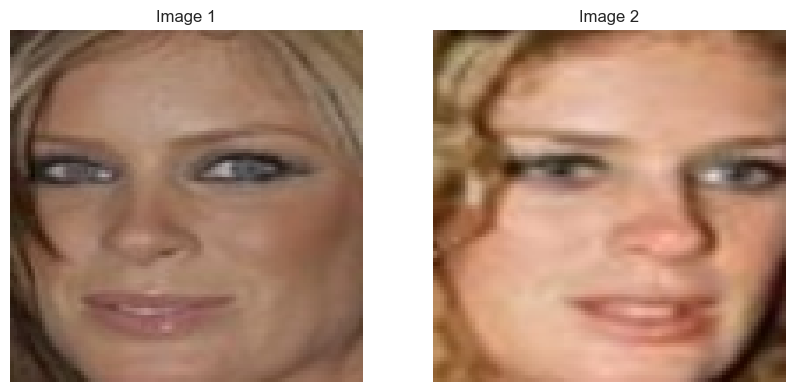

In [8]:
# Display an example sample with two iamges and the label

# Display an example sample with two images and the label
example_sample = next(iter(data))

# Unpack the example sample
example_pair, example_label = example_sample

# Display the images and the label
plt.figure(figsize=(10, 5))

# Display the first image in the pair
print("Image 1 shape:", example_pair[0][0].shape)
plt.subplot(1, 2, 1)
plt.imshow(example_pair[0][0])
plt.title("Image 1")
plt.axis("off")

# Display the second image in the pair
print("Image 2 shape:", example_pair[0][1].shape)
plt.subplot(1, 2, 2)
plt.imshow(example_pair[0][1])
plt.title("Image 2")
plt.axis("off")

# Print the label
print("Label:", example_label[0].numpy())

plt.show()

In [9]:
# Create Training and Testing datasets by percentage

train_data = data.take(int(0.7 * len(data))) # 70% of the data for training
val_data = data.skip(int(0.7 * len(data))).take(int(0.1 * len(data))) # 10% of the data for validation
test_data = data.skip(int(0.8 * len(data))) # 20% of the data for testing



In [10]:
print("Size of original dataset:", len(data))
print("Size of training dataset:", len(list(train_data.as_numpy_iterator())))
print("Size of test dataset:", len(list(test_data.as_numpy_iterator())))

Size of original dataset: 40
Size of training dataset: 28
Size of test dataset: 8


In [11]:
# Take an example batch from the training set
example_batch = next(iter(train_data))

# Unpack the example batch
example_pairs, example_labels = example_batch
example_input, example_validation = example_pairs[:, 0], example_pairs[:, 1]


# Display the shapes of the example batch
print("Shape of example anchor images :", example_input.shape)
print("Shape of example validation images :", example_validation.shape)
print("Shape of example labels:", example_labels.shape)

Shape of example anchor images : (16, 100, 100, 3)
Shape of example validation images : (16, 100, 100, 3)
Shape of example labels: (16,)


# Part 3: Build layers in model

## Objective

- Build an embedding layer / Encode Layer
- Create an L1 Distance layer
- Complie the Siamase Network

## 3.1 Build an Embedding Layer

Recall th idea, we have two stream of information (we  pass in two images: the anchor and the positive/negative image) -> Each stream will pass through an embedding layer to get the feature vector of the image -> Tow feature vectors will be used to calculate the distance between the two images at the Distance layer (here we use L1 distance).


Here is the Siamese Network architecture we are going to build:

![SiameseStructure](assets/images/SiameseStructure.png)

In the paper, it use input size of 105x105, but we will use 100x100 still okey. Therefore, **some numbers may not match exactly to the paper**

In [12]:
def make_embedding() :

    #Create the input layer
    inp = Input(shape=(100, 100, 3), name='input_image') # 100x100 image size, 3 channels color

   
    ### First Block ###
    # Next layer is a convolutional layer 64 filters, kernel size of 10x10, and ReLU activation
    c1= Conv2D(64, (10,10), activation='relu')(inp) # c1 stands for convolutional layer 1

    # Next layer is a max pooling layer with a pool size of 2x2
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1) 



    ### Second Block ###
    # Next layer is a convolutional layer 128 filters, kernel size of 7x7, and ReLU activation
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    # Next layer is a max pooling layer with a pool size of 2x2
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)



    ### Third Block ###
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    ### Fourth Block ###
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4) # Flatten the output of the convolutional layer to feed it to the dense layer
    d1 = Dense(4096, activation='sigmoid')(f1) # Dense layer with 4096 neurons and sigmoid activation

    
    return Model(inputs=[inp], outputs=[d1], name='Siamese__embedding_layer')

As show in the above image, the output of the Embedding layer is a 4096-dimensional feature vector. Two streams of information will pass through this Embedding layer then we get two 4096-dimensional feature vectors for each image. **Basicaly, we are converting the face image to a 4096-dimensional feature vector.**

In [13]:
# Summary of the model
siamese_embedding_layer = make_embedding()
siamese_embedding_layer.summary()

Model: "Siamese__embedding_layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

How to read from the summary table:

This is a 4-dimensional tensor shape where each dimension represents, for example (None,100,100,3):

- None: This represents the batch size dimension. It's set to "None" because it's flexible - you can feed any number of images through the network at once.
- 100: The height of your input images (100 pixels)
- 100: The width of your input images (100 pixels)
- 3: The number of color channels

So in plain terms, your model is expecting input images that are:

- 100x100 pixels in size
- Color in 3 channels, can be RGB, BRG or even just grayscale but duplicated 3 times to match the format.
- Can be processed in batches of any size (that's what the None indicates)

## 3.2 Create an L1 Distance Layer

Compare two feature vectors to see how similiar our two images are uisng L1 distance. The L1 distance is the sum of the absolute differences between the two feature vectors.

Since there is no L1 distance layer in Keras, we will create a custom layer to calculate the L1 distance. The custom layer will take two feature vectors as input and output the L1 distance between them.

In [14]:

class L1Dist(Layer):
    def __init__(self, **kwargs):
         super(L1Dist, self).__init__(**kwargs)
    
    def call(self,input_embedding, validation_embedding):
        
        # Convert inputs to tensors otherwise will meet error: unsupported operand type(s) for -: 'List' and 'List'
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        input_embedding = tf.squeeze(input_embedding, axis=0)  # Remove potential first dimension
        validation_embedding = tf.squeeze(validation_embedding, axis=0)

        # Calculate and return the L1 distance
        return tf.math.abs(input_embedding - validation_embedding)
    

## 3.3 Create final Siamese Network

We combine two above steps to make a fully Siamese model

In [15]:
def make_siamese_network():

    embedding_model = make_embedding()

    # Handle input images
    input_image = Input(shape=(100, 100, 3), name='input_image') # Anchor image
    validation_image = Input(shape=(100, 100, 3), name='validation_image') # Positive or negative image


    # Generate embeddings for the input images
    
    input_embedding = embedding_model(input_image)
    validation_embdedding = embedding_model(validation_image)

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(input_embedding, validation_embdedding)
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='Fully_Siamese_Network')


In [16]:
# Create the model
fully_siamese_network = make_siamese_network()
fully_siamese_network.summary()

Model: "Fully_Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Siamese__embedding… │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ Siamese__embeddi… │
│                     │                   │            │ Siamese__embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

Look at the summary table, we see that the input of the model is two images size 100,100,3. (How many images per batch is not specified, so it's flexible). The feature extraction vector (output of the Embedding layer) is **4096-dimensional**. 
The output is a **single value**, which is the distance between the two images.

# Part 4: Train the Siamese Network

## Objective

- Set up a loss function, set up an optimizer
- Establish checkpoints
- Build a Custom Training Step
- Create a Training Loop
- Train the model

## 4.1 Set up a loss function and an optimizer

In [17]:
#Define the loss function
binary_cross_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# from_logits=True is recommened when thr inputs to the loss function are not normalized 

What is this loss function?

![LossFunction](assets/images/Siamese-network_thumbnail.webp)

![LossFunction](assets/images/architecture-of-siamese-networks.webp)

![LossFunction](assets/images/The-Siamese-Architecture.png)

Beside using this Binary Crossentropy loss function, we can use other loss functions such as Contrastive Loss, Triplet Loss, etc, as this link: https://github.com/p16i/siamese-net-and-friends

In [18]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(1e-4)

There are tons of optimizer for Keras: SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam, Ftrl. We will use Adam optimizer.

## 4.2 Establish checkpoints

This checkpoint will save the model after each epoch. In case the training process is interrupted, we can resume the training from the last checkpoint.

In [19]:
# Create model model_saved folder to store trained model if it does not exist
os.makedirs('./model_saved', exist_ok=True)

# Create training_checkpoints directory inside model_saved to store checkpoints
checkpoint_dir = os.path.join('./model_saved', 'training_checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt") #Prefix for the checkpoint files with unique number
checkpoint = tf.train.Checkpoint(optimizer=optimizer, siamese_model=fully_siamese_network)

# To reload the model from the checkpoint, use model.load('path_to_checkpoint'). This will
# load pre trainweights and optimizer state into existing model

## 4.3 Build a Custom Training Step

In this step, we defined actual trainning steps. We train on one batch of data, one batch of data come through our training step, we go on makeing prediction -> calcualte our loss function -> calculate gradient then apply back popagation (calculate new weights and apply) through our neutral network to get the best possible model

In [20]:
# Initialize early stopping parameters
patience = 4
best_val_loss = float('inf')
patience_counter = 0

@tf.function  # Annotation to indicate that complies to TensorFlow graph execution 
def train_step(batch):
    with tf.GradientTape() as tape:
        # Get the pairs and labels from the batch
        pairs, labels = batch
        input_images, validation_images = pairs[:, 0], pairs[:, 1]
        
        # Forward pass
        predictions = fully_siamese_network([input_images, validation_images], training=True)
        # Set training=True for is important since some layers will only activated when this is set to True
        
        # Calculate the loss
        loss = binary_cross_loss(labels, predictions)
        
    # Calculate the gradients
    gradients = tape.gradient(loss, fully_siamese_network.trainable_variables)
    
    # Update the weights
    optimizer.apply_gradients(zip(gradients, fully_siamese_network.trainable_variables))
    # Adam is a variant of stochastic gradient descent, it applies te learning rate and gradient to slightly reduce the loss function, unitll
    # it realy near the minimum value.
    
    return loss

#define a val_step function similar to train_step but without applying gradients. It should return the loss for the validation batch.
def validate_step(batch):
    # Similar to train_step but without gradient computation
    pairs, labels = batch
    input_images, validation_images = pairs[:, 0], pairs[:, 1]
    predictions = fully_siamese_network([input_images, validation_images], training=False)
    loss = binary_cross_loss(labels, predictions)
    return loss

Recall the batch we created before:


In [21]:
# take one testing batch from train_data

example_batch = next(iter(train_data))
example_pairs, example_labels = example_batch
example_input, example_validation = example_pairs[:, 0], example_pairs[:, 1]


# Display the shapes of the example batch
print("Shape of example anchor images :", example_input.shape)
print("Shape of example validation images :", example_validation.shape)
print("Shape of example labels:", example_labels.shape)

Shape of example anchor images : (16, 100, 100, 3)
Shape of example validation images : (16, 100, 100, 3)
Shape of example labels: (16,)


## 4.4 Build Training Loop

In [22]:
def train(train_data, val_data, EPOCHS):
    global best_val_loss, patience_counter
    for epoch in range(1, EPOCHS + 1):
        print(f'\nEpoch {epoch}/{EPOCHS}')
        progressBar = tf.keras.utils.Progbar(len(train_data))
        epoch_loss = 0
        
        # Training loop
        for idx, batch in enumerate(train_data):
            loss = train_step(batch)
            epoch_loss += loss.numpy()
            progressBar.update(idx + 1, [('loss', loss.numpy())])
        
        avg_train_loss = epoch_loss / len(train_data)
        
        # Validation loop
        val_loss = 0
        for batch in val_data:
            loss = validate_step(batch)
            val_loss += loss.numpy()
        avg_val_loss = val_loss / len(val_data)
        
        print(f'Epoch {epoch} - Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}')
        
        # Check for early stopping
        # when the validation loss is not improving, we stop the training
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save the best model
            checkpoint.save(file_prefix=checkpoint_prefix)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
        
        # Save checkpoint every 10 epochs
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 4.5 Train the model

What is Epoch mean in Deep Learning model training process?

An epoch in deep learning means one complete pass through the entire training dataset.
Think of it like this:

- If you have 1000 training images
- And you're training for 10 epochs
- Your model will see all 1000 images 10 times

Each epoch helps the model:

- Learn patterns from the data
- Adjust its weights and biases
- Improve its predictions

It's like reading a textbook multiple times - each pass (epoch) helps you understand the material better. However, too many epochs can lead to overfitting, where the model memorizes the training data instead of learning general patterns.

**Uncomment to train the model**, after training it and save, comment the code to avoid retrain the model again., just load the model and use it for the next steps.

In [23]:
# Define the number of epochs
EPOCHS = 3 # Just give this a large number, early stopping will stop the training when needed

# Train the model
train(train_data, val_data, EPOCHS)


Epoch 1/3


C:\Users\Chu Trung Anh\Desktop\Biometric_IT4432E\venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(16, 100, 100, 3))
  warnings.warn(msg)
C:\Users\Chu Trung Anh\Desktop\Biometric_IT4432E\venv\Lib\site-packages\keras\src\backend\tensorflow\nn.py:750: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 0.6508
Epoch 1 - Loss: 0.6508 - Val Loss: 0.6249

Epoch 2/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - loss: 0.6154
Epoch 2 - Loss: 0.6154 - Val Loss: 0.4714

Epoch 3/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - loss: 0.5758
Epoch 3 - Loss: 0.5758 - Val Loss: 0.5278


In [24]:
# Load the model from the checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Part 5: Envaluating Model

## Objective

- Evaluate the model
- Save the model for deployment


## 5.1 Envaluate the model

In this project, we will focus on enveluating **precision** and **recall**.

- Precision: The proportion of positive identifications that were actually correct.

- Recall: The proportion of actual positives that were identified correctly.

In [25]:
# Import metrics to evaluate the model
from tensorflow.keras.metrics import  Precision, Recall

In [26]:
# Example a batch of test data
test_pair, test_labels = test_data.as_numpy_iterator().next()
test_input, test_validation = test_pair[:, 0], test_pair[:, 1]
len(test_input) # Should be 16 since we have a batch size of 16 images

16

In [27]:
# Make predictions
predictions = fully_siamese_network([test_input, test_validation])
predictions

# In each time, we passs in a batch (containing 16 anchor images + 16 positive/negative images) to the model, then we get 16 predictions for each

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[0.9136068 ],
       [0.54244566],
       [0.77970713],
       [0.7513966 ],
       [0.56942934],
       [0.7542107 ],
       [0.53550386],
       [0.5277719 ],
       [0.5680704 ],
       [0.81153893],
       [0.6947768 ],
       [0.7474619 ],
       [0.62189096],
       [0.9534782 ],
       [0.5994198 ],
       [0.58952045]], dtype=float32)>

In [28]:
# The return result for each prediction is the probability of the image pair being similar (1) or not (0), mean the return value is in the range of [0,1]
# So, we need some post processing the results by using threshold
res = []
for prediction in predictions:
    if prediction > 0.5:
        res.append(1)
    else:
        res.append(0)

res

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [29]:
## Recall ##

# Create a metric object to evaluate the model
recall = Recall()

# Update the state of the metric object
recall.update_state(test_labels, res)

# Get the result of the metric
recall.result().numpy()


1.0

In this testing, I get the result 1.0, indicate that the model is perfect in **accuracy indentify us vs others people**. However, this is just on a batch, not the whole test_data, so not the final result

In [30]:
## Precision ##

# Similiarly, we can use the Precision metric to evaluate the model
precision = Precision()
precision.update_state(test_labels, res)
precision.result().numpy()

0.8125

For more intiutive, we visualize the results

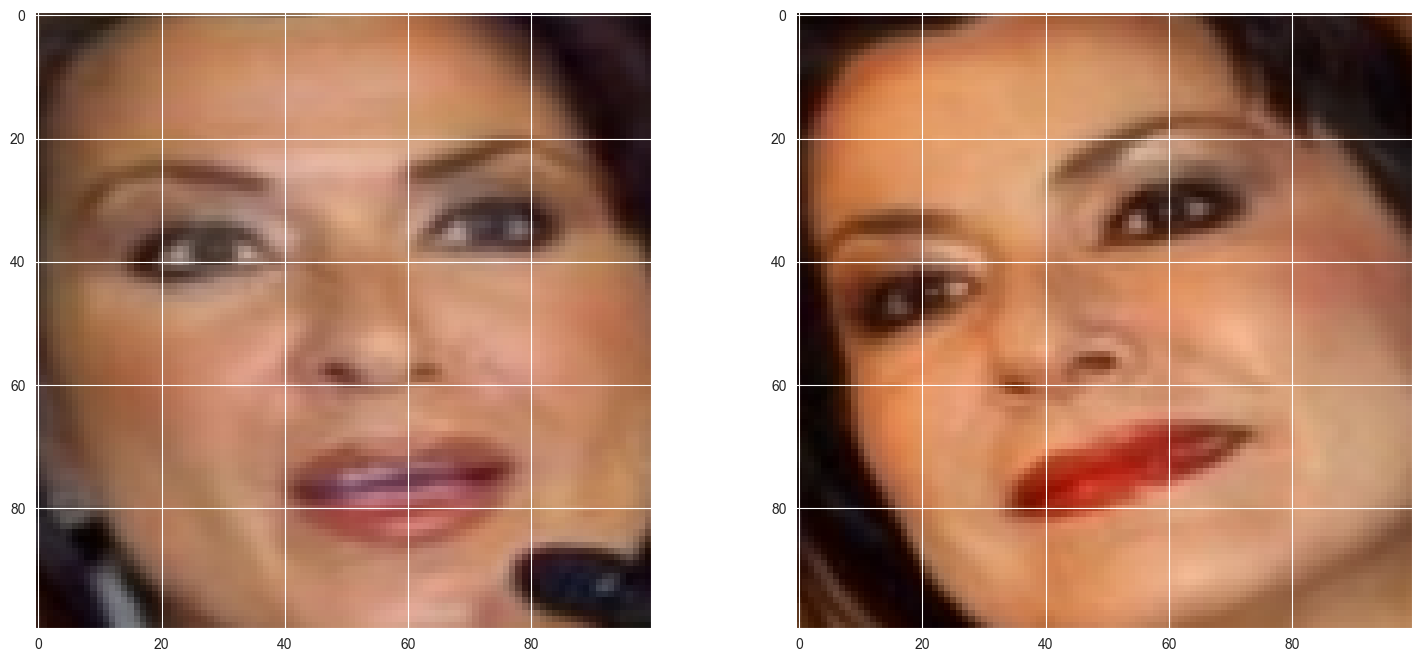

Same person


In [31]:
sample_in_batch = 0 # Choose the first image in the batch

# Set plot size
plt.figure(figsize=(18,8))

# Set subplot. The subplot function allows you to render using a grid like format
# The first argument is the number of rows, the second is the number of columns, 
# and the third is the index of the current plot
plt.subplot(1,2,1)

plt.imshow(test_input[sample_in_batch])
plt.subplot(1,2,2)
plt.imshow(test_validation[sample_in_batch])
plt.show()

# Show the label
if (test_labels[sample_in_batch] == 1):
    print("Same person")
else:
    print("NOT the same person")

C:\Users\Chu Trung Anh\Desktop\Biometric_IT4432E\venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(16, 100, 100, 3))
  warnings.warn(msg)
C:\Users\Chu Trung Anh\Desktop\Biometric_IT4432E\venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(8, 100, 100, 3))
  warnings.warn(msg)


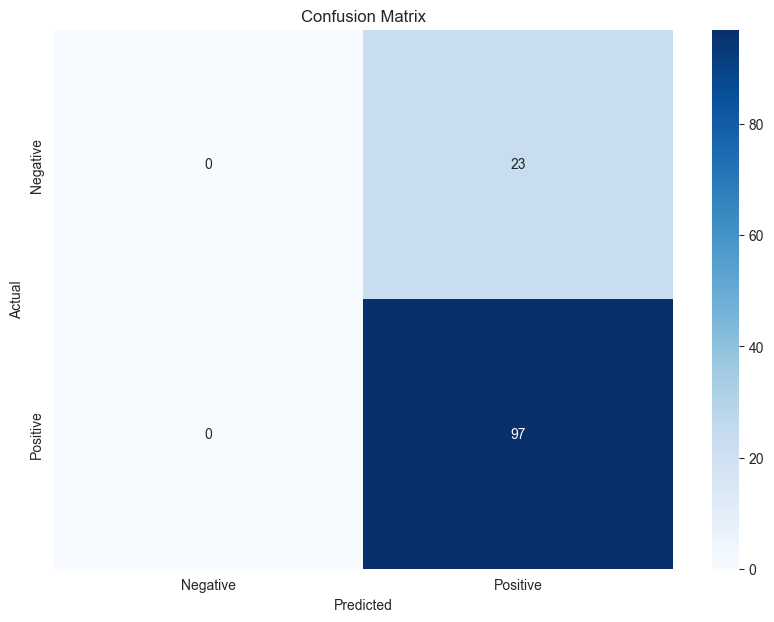

Precision: 0.8083333333333333
Recall: 1.0


In [32]:
# That is the result for an exmample batch, not we apply to the whole test data: draw the cofusion matrix and calculate the precision and recall and als
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns


# Create empty lists to store the predictions and labels
predictions = []
labels = []

# Loop through the test data
for batch in test_data:
    # Get the input images, validation images and labels from a batch
    test_pair, test_labels = batch
    test_input, test_validation = test_pair[:, 0], test_pair[:, 1]
    # Make predictions
    preds = fully_siamese_network([test_input, test_validation])
    # Append the predictions and labels to the lists
    predictions.extend(preds)
    labels.extend(test_labels) 

# Convert the lists to numpy arrays
predictions = np.array(predictions)
labels = np.array(labels)

# Apply a threshold to the predictions
threshold = 0.5
predictions = (predictions > threshold).astype(int)


# Calculate the confusion matrix
cm = confusion_matrix(labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision and recall
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)

print(f'Precision: {precision}')
print(f'Recall: {recall}')



## 5.2 Save the model

**Uncomment to save the model when run the notebook for the first time**, after that, comment the code to avoid save the model again.

In [37]:
#First, we save our model weights
fully_siamese_network.save('model_saved/fully_siamese_network.h5')

Load the model from saved file

In [34]:
## Load the model from the saved file ##
import tensorflow as tf
# Reload the model
model = tf.keras.models.load_model('model_saved/fully_siamese_network.h5', 
                                   custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy},
                                   compile=False)
# Without complie=false cause Warning: WARNING:absl:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


load_weights method can be used to load the weight also. The save_weights() method saves only the weights, the save() method saves optmizer state as well

The first parameter is the path to save the model, the second parameter is going to load our custom layers/objects. Because we got these inside our notebook alreadly, we do not need to do anything here, but when we deploy the model, we need to provide the custom objects to load the model correctly.

In [35]:
# Now to use the model, by using
model.predict([test_input, test_validation])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


array([[0.6090791 ],
       [0.60500777],
       [0.8314725 ],
       [0.5879371 ],
       [0.69557494],
       [0.79830515],
       [0.8542172 ],
       [0.6012678 ]], dtype=float32)

In [36]:
model.summary()

Model: "Fully_Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Siamese__embedding… │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ Siamese__embeddi… │
│                     │                   │            │ Siamese__embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)